# ZShapedMF (Z-shaped Membership Function)

The **Z-shaped Membership Function** (`ZShapedMF`) is a fundamental type of membership function in fuzzy logic. It provides a smooth and continuous transition from a full degree of membership (1.0) to zero. This form is ideal for modeling concepts like "**cold**" or "**slow**," where membership is high up to a certain point and then decreases gradually. The transition is defined using a cubic polynomial, resulting in a smooth curve without angular points.

## Parameters

The function is defined by two key parameters that delimit the transition region:

  - **`a` (Left Shoulder):** The point where the transition from a full degree of membership (1.0) begins. For input values less than or equal to `a`, the membership is always 1.0.
  - **`b` (Right Foot):** The point where the transition ends and the degree of membership becomes zero. For input values greater than or equal to `b`, the membership is always 0.0.

It is crucial that `a` is **less than `b`** for the transition to occur correctly.

## Mathematical Formula

The formula for the `ZShapedMF` is based on the **smoothstep function**, a third-degree polynomial. The function is defined in parts:

  - $\\mu(x) = 1$, for $x \\le a$
  - $\\mu(x) = 1 - S(t)$, where $t = \\frac{x-a}{b-a}$ and $S(t) = 3t^2 - 2t^3$, for $a \< x \< b$
  - $\\mu(x) = 0$, for $x \\ge b$

Where:

  - $\\mu(x)$ is the degree of membership of element $x$.
  - $S(t)$ is the smoothstep function, which maps a value $t$ in the interval $[0, 1]$ to a smoothly increasing value in the same interval.

## Relationship with other Membership Functions

The `ZShapedMF` is the **complement** of the S-shaped membership function (`SShapedMF`). This means that for an S-shaped function `S(x)` and a Z-shaped function `Z(x)` with the same parameters `a` and `b`, the relationship `Z(x) = 1 - S(x)` is always true.

Furthermore, a `ZShapedMF` with parameters `a` and `b` is identical to an `SShapedMF` with the parameters `b` and `a`.

$Z(x; a, b) = S(x; b, a)$

This property is useful for understanding how the two functions complement each other and can be used to model opposing concepts.

## Partial Derivatives (Gradients)

The partial derivatives are crucial for optimizing the parameters `a` and `b` in adaptive fuzzy systems. They show how the function's output changes in response to small changes in these parameters.

### Derivative with respect to `a` ($\\frac{\\partial \\mu}{\\partial a}$)

This derivative indicates how the degree of membership is affected by adjusting the starting point of the transition.

> $$\frac{\partial \mu}{\partial a} = \frac{\partial \mu}{\partial t} \frac{\partial t}{\partial a} = - (6t(t-1)) \cdot \frac{x-b}{(b-a)^2}$$

### Derivative with respect to `b` ($\\frac{\\partial \\mu}{\\partial b}$)

This derivative indicates how the degree of membership is affected by adjusting the endpoint of the transition.

> $$\frac{\partial \mu}{\partial b} = \frac{\partial \mu}{\partial t} \frac{\partial t}{\partial b} = - (6t(t-1)) \cdot - \frac{x-a}{(b-a)^2}$$

## Python Example and Visualization

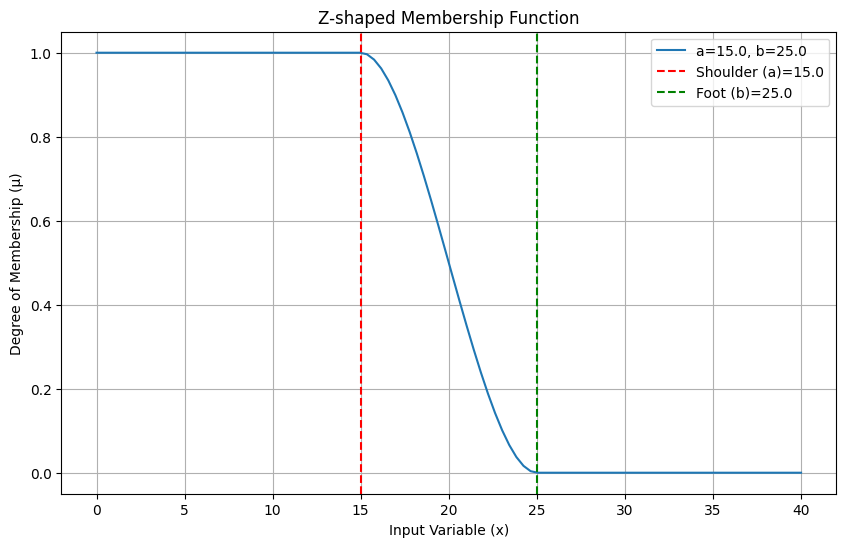

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# The base class and helper functions from your code
class MembershipFunction:
    def __init__(self):
        self.parameters = {}
        self.gradients = {}
        self.last_input = None
        self.last_output = None
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x)

def _smoothstep(t: np.ndarray) -> np.ndarray:
    return 3.0 * t**2 - 2.0 * t**3

def _dsmoothstep_dt(t: np.ndarray) -> np.ndarray:
    return 6.0 * t * (1.0 - t)

# The ZShapedMF class
class ZShapedMF(MembershipFunction):
    """Z-shaped Membership Function."""
    def __init__(self, a: float, b: float):
        super().__init__()
        if not (a < b):
            raise ValueError(f"Parameters must satisfy a < b, got a={a}, b={b}")
        self.parameters = {"a": float(a), "b": float(b)}
        self.gradients = {"a": 0.0, "b": 0.0}

    def forward(self, x: np.ndarray) -> np.ndarray:
        x = np.asarray(x)
        self.last_input = x.copy()
        a, b = self.parameters["a"], self.parameters["b"]
        y = np.zeros_like(x, dtype=np.float64)
        mask_left = x <= a
        y[mask_left] = 1.0
        mask_trans = (x > a) & (x < b)
        if np.any(mask_trans):
            x_t = x[mask_trans]
            t = (x_t - a) / (b - a)
            y[mask_trans] = 1.0 - _smoothstep(t)
        self.last_output = y.copy()
        return y

    def backward(self, dL_dy: np.ndarray):
        if self.last_input is None or self.last_output is None:
            return
        x = self.last_input
        dL_dy = np.asarray(dL_dy)
        a, b = self.parameters["a"], self.parameters["b"]
        mask = (x >= a) & (x <= b)
        if not (np.any(mask) and b != a):
            return
        x_t = x[mask]
        dL_dy_t = dL_dy[mask]
        t = (x_t - a) / (b - a)
        dZ_dt = -_dsmoothstep_dt(t)
        dt_da = (x_t - b) / (b - a) ** 2
        dt_db = -(x_t - a) / (b - a) ** 2
        dZ_da = dZ_dt * dt_da
        dZ_db = dZ_dt * dt_db
        self.gradients["a"] += float(np.sum(dL_dy_t * dZ_da))
        self.gradients["b"] += float(np.sum(dL_dy_t * dZ_db))

# --- Start of visualization code ---

# Create an instance of the Z-shaped MF
mf = ZShapedMF(a=15, b=25)

# Generate a range of x values
x_values = np.linspace(0, 40, 100)

# Compute the membership values for each x
membership_values = mf.forward(x_values)

# Configure and plot the chart
plt.figure(figsize=(10, 6))
plt.plot(x_values, membership_values, label=f'a={mf.parameters["a"]}, b={mf.parameters["b"]}')

# Add vertical lines for parameters 'a' and 'b'
plt.axvline(mf.parameters['a'], color='r', linestyle='--', label=f'Shoulder (a)={mf.parameters["a"]}')
plt.axvline(mf.parameters['b'], color='g', linestyle='--', label=f'Foot (b)={mf.parameters["b"]}')

plt.title('Z-shaped Membership Function')
plt.xlabel('Input Variable (x)')
plt.ylabel('Degree of Membership (μ)')
plt.legend()
plt.grid(True)
plt.show()